In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fnmatch
%matplotlib inline

/home/mbeeg/programs/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from scipy.integrate import odeint
from scipy import integrate, rand
from scipy.optimize import fmin, leastsq

In [3]:
def fitfunc_model1(param,initial_cond,constants):
    #-time-grid-----------------------------------
    start_t,end_t,incr,t_ct,cA=constants
    ka,kd,Rmax=param

    t  = np.linspace(start_t, end_t,incr)
    t_round=t.round(0)
    ind_t_ct = np.where(t_round==t_ct)[0][-1]
    t_ass = t[:ind_t_ct]
    t_diss = t[ind_t_ct:]-t_ct
    #print t_ass,t_diss
    #differential-eq-system----------------------

    def funct_ass(y,t):
        Rt=y[0]
        #ka,kd,Rmax=par
        # the model equations for association(see Biorad)
        #dABs_dt = alpha*(ka1*A*(B-AB-ABs)-kd1*ABs-k2*ABs+k_2*AB)
        #dAB_dt =beta*(k2*ABs-k_2*AB)
        dRt_dt = ka*cA*(Rmax-Rt)-kd*Rt
        return dRt_dt

    def funct_diss(y,t):
        Rt=y[0]
        dRt_dt = -kd*Rt
        #ka,kd,Rmax=par
        # the model equations for dissociation (see see Biorad)
        return dRt_dt

    #integrate------------------------------------
    dsa = integrate.odeint(funct_ass,initial_cond,t_ass)
    dsd = integrate.odeint(funct_diss,dsa[-1],t_diss)

    t_int = np.hstack((t_ass,t_ass[-1]+t_diss))
    Rt_int = np.hstack((dsa[:,0],dsd[:,0]))

    #print Rt_int.shape, t_int.shape
    return Rt_int,t_int
    #return (np.hstack((dsa,dsd[:,0])),np.hstack((dsa[:,1],dsd[:,1])),np.hstack((t_ass,t_ass[-1]+t_diss))) 

#3.Score Fit of System
#=========================================================
def errfunc_model1(params, y0, constants, RUdata, mindex):
    #a.Get Solution to system
    Rt,T=fitfunc_model1(params,y0,constants)
    RUmodel=Rt[mindex]
    return RUdata-RUmodel    #a.Get Solution to system

#========================================================


In [4]:
#3.Score Fit of System
#=========================================================
def errfunc_model1_multi_2(params, y0, constants, RUdata, mindex):
    params1 = param[0:3] 
    Rt1,T=fitfunc_model1(params,y0,constants)
    params2 = param[3:]
    Rt2,T=fitfunc_model1(params,y0,constants)
    Rt = Rt1 + Rt2
    RUmodel=Rt[mindex]
    return RUdata-RUmodel
#========================================================

In [5]:
#3.Score Fit of System
#=========================================================
def errfunc_model1_multi_het(params, y0, constants, df_data):
    y0_model1 = y0[0];y0_model2 = y0[1]; y0_data = y0[0] + y0[1]
    RU_model_all=np.array([])
    RU_all=np.array([])
    lst_conc=constants[-1]
    for i in range(0,len(lst_conc),1):
        t_data = np.array(df_data[df_data.columns[0]])
        signal_data = np.array(df_data[df_data.columns[i+1]])
        const=(constants[0],constants[1],constants[2],constants[3],lst_conc[i])
        #a.Get Solution to system
        params1 = params[0:3]
        #print params1, lst_conc[i]
        signal_model1,t_model=fitfunc_model1(params1,y0_model1,const)
        params2 = params[3:]
        signal_model2,t_model=fitfunc_model1(params2,y0_model2,const)
        signal_model = signal_model1 + signal_model2
        mindex = t_model.searchsorted(t_data)
        mindex = mindex.tolist()
        signal_model = signal_model[mindex]
        if len(RU_model_all)==0:
            RU_model_all=signal_model
            RU_all=signal_data + y0_data
        else:
            RU_model_all=np.hstack((RU_model_all,signal_model))        
            RU_all=np.hstack((RU_all,signal_data + y0_data))
        y0_model1 = signal_model1[-1]
        y0_model2 = signal_model2[-1]
        y0_data = signal_data[-1] + y0_data
        #print y0_model, y0_data
    #RUmodel=F0[mindex]
    #print np.sum(RU_all - RU_model_all)
    return RU_all - RU_model_all
#======

In [52]:
#3.Score Fit of System
#=========================================================
def errfunc_model1_multi_het3(params, y0, constants, df_data):
    y0_model1 = y0[0];y0_model2 = y0[1]; y0_model3 = y0[2]; y0_data = y0[0] + y0[1]
    RU_model_all=np.array([])
    RU_all=np.array([])
    lst_conc=constants[-1]
    for i in range(0,len(lst_conc),1):
        t_data = np.array(df_data[df_data.columns[0]])
        signal_data = np.array(df_data[df_data.columns[i+1]])
        const=(constants[0],constants[1],constants[2],constants[3],lst_conc[i])
        #a.Get Solution to system
        params1 = params[0:3]

        signal_model1,t_model=fitfunc_model1(params1,y0_model1,const)
        params2 = params[3:6]

        signal_model2,t_model=fitfunc_model1(params2,y0_model2,const)
        params3 = params[6:]

        signal_model3,t_model=fitfunc_model1(params3,y0_model3,const)
        
        signal_model = signal_model1 + signal_model2 + signal_model3
        mindex = t_model.searchsorted(t_data)
        mindex = mindex.tolist()
        signal_model = signal_model[mindex]
        if len(RU_model_all)==0:
            RU_model_all=signal_model
            RU_all=signal_data + y0_data
        else:
            RU_model_all=np.hstack((RU_model_all,signal_model))        
            RU_all=np.hstack((RU_all,signal_data + y0_data))
        y0_model1 = signal_model1[-1]
        y0_model2 = signal_model2[-1]
        y0_model3 = signal_model3[-1]
        y0_data = signal_data[-1] + y0_data
        #print y0_model, y0_data
    #RUmodel=F0[mindex]
    #print np.sum(RU_all - RU_model_all)
    return RU_all - RU_model_all
#======

In [45]:
def errfunc_model1_multi_het3_test(params, y0, constants, df_data):
    y0_model1 = y0[0];y0_model2 = y0[1]; y0_model3 = y0[2]; y0_data = y0[0] + y0[1]
    RU_model_all=np.array([])
    RU_all=np.array([])
    lst_conc=constants[-1]
    for i in range(0,len(lst_conc),1):
        t_data = np.array(df_data[df_data.columns[0]])
        signal_data = np.array(df_data[df_data.columns[i+1]])
        const=(constants[0],constants[1],constants[2],constants[3],lst_conc[i])
        #a.Get Solution to system
        params1 = params[0:3]
        print params1
        #print params1, lst_conc[i]
        signal_model1,t_model=fitfunc_model1(params1,y0_model1,const)
        params2 = params[3:6]
        print params2
        signal_model2,t_model=fitfunc_model1(params2,y0_model2,const)
        params3 = params[6:]
        print params3
        signal_model3,t_model=fitfunc_model1(params3,y0_model3,const)
        signal_model = signal_model1 + signal_model2 + signal_model3
        mindex = t_model.searchsorted(t_data)
        mindex = mindex.tolist()
        signal_model = signal_model[mindex]
        if len(RU_model_all)==0:
            RU_model_all=signal_model
            RU_all=signal_data + y0_data
        else:
            RU_model_all=np.hstack((RU_model_all,signal_model))        
            RU_all=np.hstack((RU_all,signal_data + y0_data))
        y0_model1 = signal_model1[-1]
        y0_model2 = signal_model2[-1]
        y0_model3 = signal_model3[-1]
        y0_data = signal_data[-1] + y0_data
        #print y0_model, y0_data
    #RUmodel=F0[mindex]
    #print np.sum(RU_all - RU_model_all)
    return [RU_all, RU_model_all]

In [6]:
#3.Score Fit of System
#=========================================================
def errfunc_model1_multi(params, y0, constants, df_data):
    y0_model = y0; y0_data = y0[0]
    RU_model_all=np.array([])
    RU_all=np.array([])
    lst_conc=constants[-1]
    for i in range(0,len(lst_conc),1):
        t_data = np.array(df_data[df_data.columns[0]])
        signal_data = np.array(df_data[df_data.columns[i+1]])
        const=(constants[0],constants[1],constants[2],constants[3],lst_conc[i])
        #a.Get Solution to system       
        signal_model,t_model=fitfunc_model1(params,y0_model,const)
        mindex = t_model.searchsorted(t_data)
        mindex = mindex.tolist()
        signal_model = signal_model[mindex]
        if len(RU_model_all)==0:
            RU_model_all=signal_model
            RU_all=signal_data + y0_data
        else:
            RU_model_all=np.hstack((RU_model_all,signal_model))        
            RU_all=np.hstack((RU_all,signal_data + y0_data))
        y0_model = [signal_model[-1]]
        y0_data = signal_data[-1] + y0_data
        #print y0_model, y0_data
    #RUmodel=F0[mindex]
    #print np.sum(RU_all - RU_model_all)
    return RU_all - RU_model_all
#======

In [14]:
df = pd.read_excel("dati per Marten rhFCN1 e NAG-BSA diretto.xlsx")

In [15]:
df[0:2]

,time(s),NAG-100,NAG-300,NAG-800
0,0.0,0.35,0.35,0.35
1,0.9,2.31,2.31,0.88


In [16]:
df.tail(2)

,time(s),NAG-100,NAG-300,NAG-800
875,787.5,26.18,39.61,43.95
876,788.4,25.53,40.88,44.51


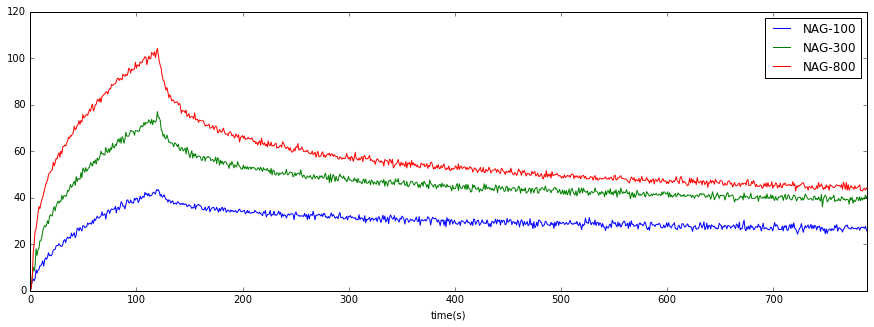

In [73]:
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
df.plot(x=["time(s)"], y=["NAG-100","NAG-300","NAG-800"],  ax=ax)
plt.savefig("20180201_data.png",dpi=600)

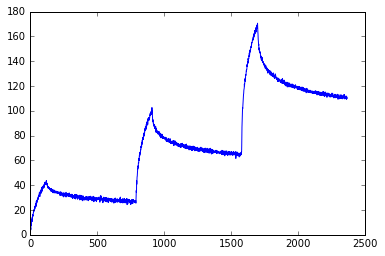

In [74]:
lst_col = ["NAG-100","NAG-300","NAG-800"]
#lst_col = ["MAN-3","MAN-10","MAN-30","MAN-100"]
RUdata = np.array([]); tdata = np.array([]); t0 = 0; y0 = 0
for i in range(0,len(lst_col),1):
    AB = np.array(df[lst_col[i]])
    t = np.array(df["time(s)"])
    if len(RUdata) == 0:
        RUdata = y0 + AB
        tdata = t0 + t
    else:
        RUdata = np.hstack((RUdata,y0 + AB))
        tdata = np.hstack((tdata,t0 + t))
    y0 = RUdata[-1]
    t0 = tdata[-1]
plt.plot(tdata,RUdata) 

In [75]:
c_lst = [100e-9,300e-9,800e-9]
ka = 1e5
kd = 1e-6
Rmax = 500

start_time=0
t_contact=120 #min
end_time=788.4
time=df["time(s)"]
intervall = 3000

Rt = 0
y0 = [Rt]

param=(ka,kd,Rmax)
#param=rates
df_data = df[["time(s)","NAG-100","NAG-300","NAG-800"]].copy()
#df_data = df[["time(s)","MAN-3","MAN-10","MAN-30","MAN-100"]].copy()
const=(start_time,end_time,intervall,t_contact,c_lst)
ParamFit_single=leastsq(errfunc_model1_multi,param[:],args=(y0,const,df_data))

In [76]:
print str('{:0.2e}'.format(ParamFit_single[0][0]))+"\t"+str('{:0.2e}'.format(ParamFit_single[0][1]))+"\t"+str(ParamFit_single[0][2].round())

2.05e+04	5.81e-04	164.0


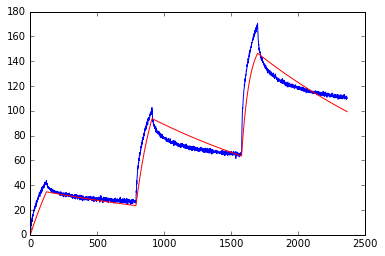

In [77]:
Param = ParamFit_single[0]
Fit_overall = np.array([]); y0 = 0
t_overall = np.array([]); t0 = 0
for ca in c_lst:
    const=(start_time,end_time,intervall,t_contact,ca)
    AB_model,t_model=fitfunc_model1(Param,y0,const)

    if len(Fit_overall)==0:
        Fit_overall=AB_model
        t_overall = t0 + t_model
    else:
        Fit_overall=np.hstack((Fit_overall,AB_model))
        t_overall=np.hstack((t_overall,t0 + t_model))
    y0 = [Fit_overall[-1]]
    t0 = t_overall[-1]
plt.plot(tdata,RUdata)
plt.plot(t_overall,Fit_overall,"r")
plt.savefig("20180201_fit_1component.png",dpi=600)

In [78]:
c_lst = [100e-9,300e-9,800e-9]
ka1 = 1e5
kd1 = 1e-4
Rmax1 = 400

ka2 = 1e6
kd2 = 1e-1
Rmax2 = 300

start_time=0
t_contact=120 #min
end_time=788.4
time=df["time(s)"]
intervall = 3000

Rt = 0
y0 = [Rt,Rt]

param=(ka1,kd1,Rmax1,ka2,kd2,Rmax2)
#param=rates
df_data = df[["time(s)","NAG-100","NAG-300","NAG-800"]].copy()
#df_data = df[["time(s)","MAN-3","MAN-10","MAN-30","MAN-100"]].copy()
const=(start_time,end_time,intervall,t_contact,c_lst)
ParamFit=leastsq(errfunc_model1_multi_het,param[:],args=(y0,const,df_data))

In [79]:
print "single:"
print "ka = "+str('{:0.2e}'.format(ParamFit_single[0][0]))+"\tkd = "+str('{:0.2e}'.format(ParamFit_single[0][1]))+"\tRmax = "+str(ParamFit_single[0][2].round())
print "\nheterogenous:"
print "ka1 = "+str('{:0.2e}'.format(ParamFit[0][0]))+"\tkd1 = "+str('{:0.2e}'.format(ParamFit[0][1]))+"\tRmax1 = "+str(ParamFit[0][2].round())
print "ka2 = "+str('{:0.2e}'.format(ParamFit[0][3]))+"\tkd2 = "+str('{:0.2e}'.format(ParamFit[0][4]))+"\tRmax2 = "+str(ParamFit[0][5].round())

single:
ka = 2.05e+04	kd = 5.81e-04	Rmax = 164.0

heterogenous:
ka1 = 1.75e+04	kd1 = 3.12e-04	Rmax1 = 149.0
ka2 = 2.06e+05	kd2 = 3.65e-02	Rmax2 = 41.0


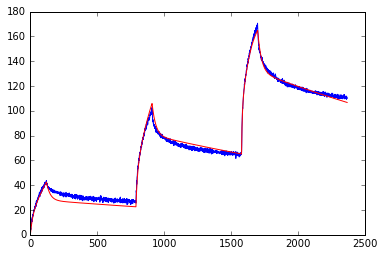

In [80]:
c_lst = [100e-9,300e-9,800e-9]

Param = ParamFit[0]
Fit_overall1 = np.array([]);Fit_overall2 = np.array([]); y0 = [0,0]
t_overall = np.array([]); t0 = 0
for ca in c_lst:
    const=(start_time,end_time,intervall,t_contact,ca)
    Param1 = Param[0:3]
    AB_model1,t_model=fitfunc_model1(Param1,y0[0],const)
    Param2 = Param[3:]
    AB_model2,t_model=fitfunc_model1(Param2,y0[1],const)
    
    if len(Fit_overall)==0:
        Fit_overall1=AB_model1
        Fit_overall2=AB_model2
        t_overall = t0 + t_model
    else:
        Fit_overall1=np.hstack((Fit_overall1,AB_model1))
        Fit_overall2=np.hstack((Fit_overall2,AB_model2))
        t_overall=np.hstack((t_overall,t0 + t_model))
    y0 = [Fit_overall1[-1],Fit_overall2[-1]]
    t0 = t_overall[-1]
plt.plot(tdata,RUdata)
plt.plot(t_overall,Fit_overall1+Fit_overall2,"r")
plt.savefig("20180201_fit_2component.png",dpi=600)

In [81]:
c_lst = [100e-9,300e-9,800e-9]
ka1 = 1.74e4
kd1 = 3.12e-4
Rmax1 = 149

ka2 = 2.06e5
kd2 = 3.65e-2
Rmax2 = 41

ka3 = 2.06e5
kd3 = 3.65e-2
Rmax3 = 41

start_time=0
t_contact=120 #min
end_time=788.4
time=df["time(s)"]
intervall = 3000

Rt = 0
y0 = [Rt,Rt,Rt]

param=(ka1,kd1,Rmax1,ka2,kd2,Rmax2,ka3,kd3,Rmax3)
#param=rates
df_data = df[["time(s)","NAG-100","NAG-300","NAG-800"]].copy()
#df_data = df[["time(s)","MAN-3","MAN-10","MAN-30","MAN-100"]].copy()
const=(start_time,end_time,intervall,t_contact,c_lst)
ParamFit=leastsq(errfunc_model1_multi_het3,param[:],args=(y0,const,df_data))

In [82]:
print "ka1 = "+str('{:0.2e}'.format(ParamFit[0][0]))+"\tkd1 = "+str('{:0.2e}'.format(ParamFit[0][1]))+"\tRmax1 = "+str(ParamFit[0][2].round())
print "ka2 = "+str('{:0.2e}'.format(ParamFit[0][3]))+"\tkd2 = "+str('{:0.2e}'.format(ParamFit[0][4]))+"\tRmax2 = "+str(ParamFit[0][5].round())
print "ka3 = "+str('{:0.2e}'.format(ParamFit[0][6]))+"\tkd3 = "+str('{:0.2e}'.format(ParamFit[0][7]))+"\tRmax3 = "+str(ParamFit[0][8].round())

ka1 = 1.30e+04	kd1 = 2.30e-04	Rmax1 = 142.0
ka2 = 2.23e+05	kd2 = 6.60e-04	Rmax2 = 15.0
ka3 = 8.52e+04	kd3 = 3.70e-02	Rmax3 = 58.0


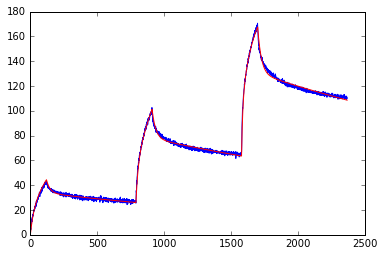

In [83]:
c_lst = [100e-9,300e-9,800e-9]

Param = ParamFit[0]
Fit_overall1 = np.array([]);Fit_overall2 = np.array([]);Fit_overall3 = np.array([]); y0 = [0,0,0]
t_overall = np.array([]); t0 = 0
for ca in c_lst:
    const=(start_time,end_time,intervall,t_contact,ca)
    Param1 = Param[0:3]
    AB_model1,t_model=fitfunc_model1(Param1,y0[0],const)
    Param2 = Param[3:6]
    AB_model2,t_model=fitfunc_model1(Param2,y0[1],const)
    Param3 = Param[6:]
    AB_model3,t_model=fitfunc_model1(Param3,y0[2],const)    
    if len(Fit_overall)==0:
        Fit_overall1=AB_model1
        Fit_overall2=AB_model2
        Fit_overall3=AB_model3
        t_overall = t0 + t_model
    else:
        Fit_overall1=np.hstack((Fit_overall1,AB_model1))
        Fit_overall2=np.hstack((Fit_overall2,AB_model2))
        Fit_overall3=np.hstack((Fit_overall3,AB_model3))
        t_overall=np.hstack((t_overall,t0 + t_model))
    y0 = [Fit_overall1[-1],Fit_overall2[-1],Fit_overall3[-1]]
    t0 = t_overall[-1]
plt.plot(tdata,RUdata)
plt.plot(t_overall,Fit_overall1+Fit_overall2+Fit_overall3,"r")
plt.savefig("20180201_fit_3component.png",dpi=600)